In [1]:
import pathlib
import skimage
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
im_dir = pathlib.Path('F:/device/optics/32w_Realtime_test_5th/1')

In [3]:
temp_li = ['Low Temp', 'High Temp']

In [4]:
x_range = slice(400, 1900)
y_range = slice(400, 1900)

In [5]:
im_dict = {'Low Temp': {}, 'High Temp': {}}
for c in range(45):
    for t in range(2):
        im_dict[temp_li[t]][c] = {}
        fpath = im_dir/f'{c}_{t}_3.jpg'
        im = np.array(Image.open(fpath))
        im_dict[temp_li[t]][c]['original'] = im
        
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_cropped = im_gray[x_range, y_range]
        im_dict[temp_li[t]][c]['gray'] = im_cropped
        
        thresh = skimage.filters.threshold_mean(im_cropped)
        threshed_im = im_cropped > thresh
        im_dict[temp_li[t]][c]['thresh'] = threshed_im
        
        bw = skimage.morphology.closing(threshed_im, skimage.morphology.disk(3))
        bw2 = skimage.morphology.opening(bw, skimage.morphology.disk(3))
        cleared = skimage.segmentation.clear_border(bw2)
        label_image = skimage.measure.label(cleared)
        im_dict[temp_li[t]][c]['labeled'] = label_image
        

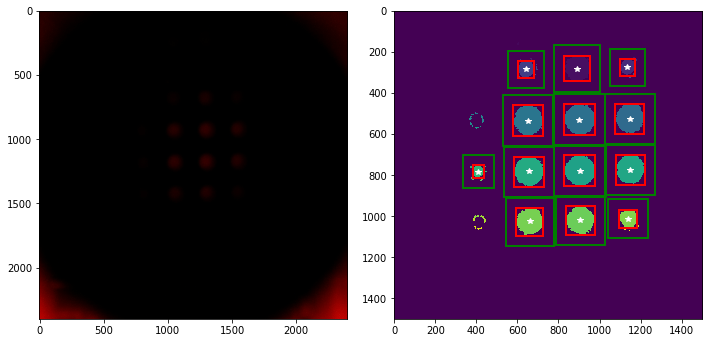

In [6]:
im_orig = im_dict[temp_li[1]][44]['original']
im_gray = im_dict[temp_li[1]][44]['gray']
im_labeled = im_dict[temp_li[1]][44]['labeled']

fig, ax = plt.subplots(1, 2, figsize=(10, 12))
ax[0].imshow(im_orig)
ax[1].imshow(im_labeled)
region_li = []
i = 0
j = 1
row = list('ABCD')
region_raw = []
for region in skimage.measure.regionprops(im_labeled, intensity_image=im_gray):
    # take regions with large enough areas
    region_raw.append(region)
    if 500 <= region.area < 30000:
        # draw rectangle around segmented coins
        region_li.append(region)
        minr, minc, maxr, maxc = region.bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax[1].add_patch(rect)
        rect2 = matplotlib.patches.Rectangle((minc-50, minr-50), maxc - minc+100, maxr - minr+100, fill=False, edgecolor='green', linewidth=2)
        ax[1].add_patch(rect2)
        ax[1].plot(region.centroid[1], region.centroid[0], color='white', marker='*')

plt.tight_layout()
plt.show()

Text(0.5,1,'49')

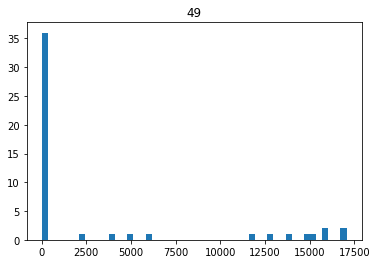

In [7]:
region_area = [region.area for region in region_raw]
plt.hist(region_area, bins=50)
plt.title(len(region_raw))

Text(0.5,1,'Min')

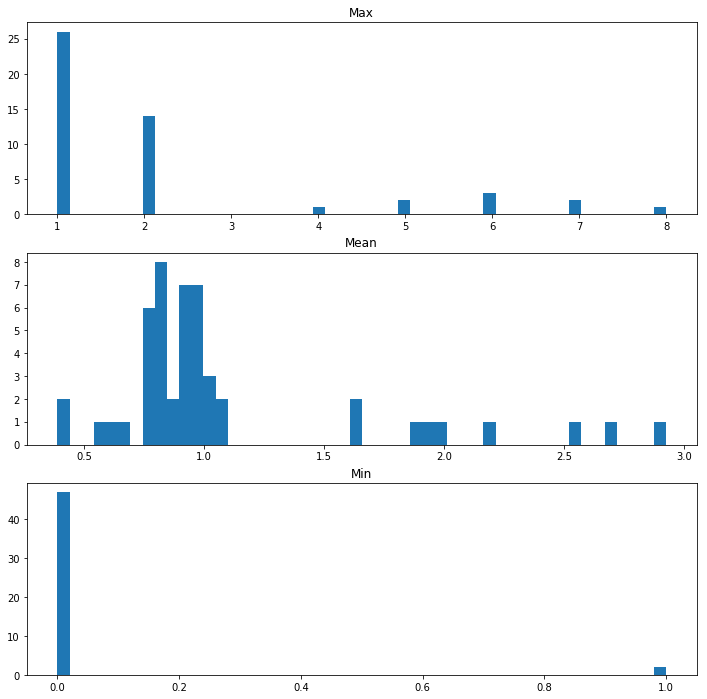

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
region_max_intensity = [region.max_intensity for region in region_raw]
ax[0].hist(region_max_intensity, bins=50)
ax[0].set_title('Max')
region_mean_intensity  = [region.mean_intensity  for region in region_raw]
ax[1].hist(region_mean_intensity, bins=50)
ax[1].set_title('Mean')
region_min_intensity = [region.min_intensity for region in region_raw]
ax[2].hist(region_min_intensity, bins=50)
ax[2].set_title('Min')

In [9]:
well_location_key = []
for r in range(1, 5):
    for c in list('ABCD')[::-1]:
        well_location_key.append(c+str(r))
cent_li = []
for r in region_li:
    y, x = r.centroid
    cent_li.append([x//100, y//100, region_li.index(r)])
cent_li.sort()
cent_li

c:\users\ympai\scoop\apps\python36\current\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
c:\users\ympai\scoop\apps\python36\current\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


[[4.0, 7.0, 9],
 [6.0, 2.0, 2],
 [6.0, 5.0, 5],
 [6.0, 7.0, 8],
 [6.0, 10.0, 11],
 [8.0, 2.0, 0],
 [9.0, 5.0, 4],
 [9.0, 7.0, 6],
 [9.0, 10.0, 10],
 [11.0, 2.0, 1],
 [11.0, 5.0, 3],
 [11.0, 7.0, 7],
 [11.0, 10.0, 12]]

In [10]:
len(cent_li)

13

In [11]:
minr_li = []
minc_li = []
maxr_li = []
maxc_li = []
for r in region_li:
    minr, minc, maxr, maxc = r.bbox
    minr_li.append(minr)
    minc_li.append(minc)
    maxr_li.append(maxr)
    maxc_li.append(maxc)
minr_li.sort()
top = minr_li[0]
minc_li.sort()
left = minc_li[0]
maxr_li.sort()
bottom = maxr_li[-1]
maxc_li.sort()
right = maxc_li[-1]

well_box = [top-50, left-50, bottom+50, right+50]

In [12]:
well_box

[168, 336, 1144, 1272]

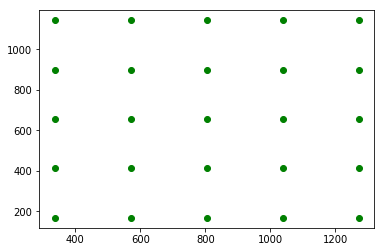

In [13]:
y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
pts_x = []
pts_y = []
for x in x_li:
    for y in y_li:
        pts_x.append(x)
        pts_y.append(y)
plt.figure()
plt.scatter(pts_x, pts_y, c='g')

In [14]:
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

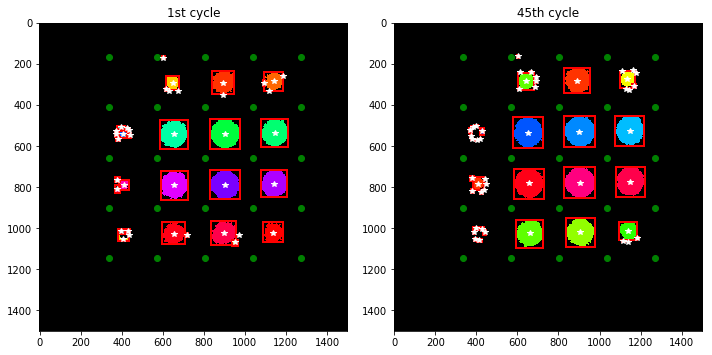

In [15]:
im_labeled0 = im_dict[temp_li[1]][0]['labeled']
im_gray0 = im_dict[temp_li[1]][44]['gray']
image_label_overlay0 = skimage.color.label2rgb(im_labeled0, bg_label=0, colors=colors_li)

im_labeled44 = im_dict[temp_li[1]][44]['labeled']
im_gray44 = im_dict[temp_li[1]][44]['gray']
image_label_overlay44 = skimage.color.label2rgb(im_labeled44, bg_label=0, colors=colors_li)

fig, ax = plt.subplots(1, 2, figsize=(10, 12))
ax[0].imshow(image_label_overlay0)
ax[0].scatter(pts_x, pts_y, c='g')
ax[1].imshow(image_label_overlay44)
ax[1].scatter(pts_x, pts_y, c='g')

for region in skimage.measure.regionprops(im_labeled0, intensity_image=im_gray0):
    minr, minc, maxr, maxc = region.bbox
    rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax[0].add_patch(rect)
    ax[0].plot(region.centroid[1], region.centroid[0], color='white', marker='*')
    ax[0].set_title('1st cycle')

for region in skimage.measure.regionprops(im_labeled44, intensity_image=im_gray44):
    minr, minc, maxr, maxc = region.bbox
    rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax[1].add_patch(rect)
    ax[1].plot(region.centroid[1], region.centroid[0], color='white', marker='*')
    ax[1].set_title('45th cycle')


plt.tight_layout()
plt.show()

In [16]:
pts_li = list(zip(pts_x, pts_y))
pts_li

[(336.0, 168.0),
 (336.0, 412.0),
 (336.0, 656.0),
 (336.0, 900.0),
 (336.0, 1144.0),
 (570.0, 168.0),
 (570.0, 412.0),
 (570.0, 656.0),
 (570.0, 900.0),
 (570.0, 1144.0),
 (804.0, 168.0),
 (804.0, 412.0),
 (804.0, 656.0),
 (804.0, 900.0),
 (804.0, 1144.0),
 (1038.0, 168.0),
 (1038.0, 412.0),
 (1038.0, 656.0),
 (1038.0, 900.0),
 (1038.0, 1144.0),
 (1272.0, 168.0),
 (1272.0, 412.0),
 (1272.0, 656.0),
 (1272.0, 900.0),
 (1272.0, 1144.0)]

In [17]:
well_location_dict = {}
row = list('ABCD')[::-1]
i = 0
for x in range(4):
    for y in range(4):
        key = row[y]+str(x+1)
        top_left_pt = pts_li[i+y+x]
        bottom_right_pt = pts_li[i+y+x+6]
        well_location_dict[key] = [top_left_pt[1], top_left_pt[0], bottom_right_pt[1], bottom_right_pt[0]]
    i += 4
    
well_location_dict

{'D1': [168.0, 336.0, 412.0, 570.0],
 'C1': [412.0, 336.0, 656.0, 570.0],
 'B1': [656.0, 336.0, 900.0, 570.0],
 'A1': [900.0, 336.0, 1144.0, 570.0],
 'D2': [168.0, 570.0, 412.0, 804.0],
 'C2': [412.0, 570.0, 656.0, 804.0],
 'B2': [656.0, 570.0, 900.0, 804.0],
 'A2': [900.0, 570.0, 1144.0, 804.0],
 'D3': [168.0, 804.0, 412.0, 1038.0],
 'C3': [412.0, 804.0, 656.0, 1038.0],
 'B3': [656.0, 804.0, 900.0, 1038.0],
 'A3': [900.0, 804.0, 1144.0, 1038.0],
 'D4': [168.0, 1038.0, 412.0, 1272.0],
 'C4': [412.0, 1038.0, 656.0, 1272.0],
 'B4': [656.0, 1038.0, 900.0, 1272.0],
 'A4': [900.0, 1038.0, 1144.0, 1272.0]}

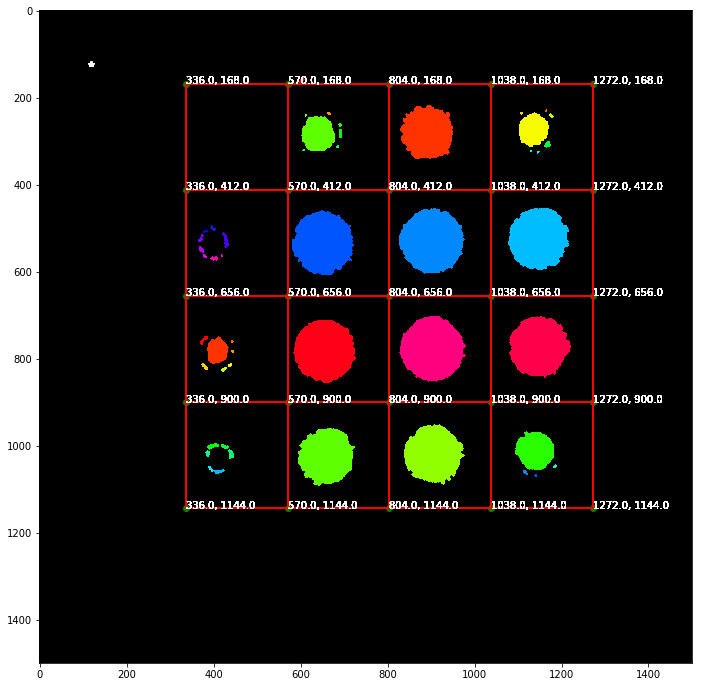

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(pts_x, pts_y, c='g')
for x in pts_x:
    for y in pts_y:
        plt.text(x, y, f'{x}, {y}', color='w')
ax.imshow(image_label_overlay44)
for well in well_location_dict.keys():
    minr, minc, maxr, maxc = well_location_dict[well]
    rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.plot((maxc - minc)/2, (maxr - minr)/2, color='white', marker='*')


In [70]:
def get_well_loc(x, y, pts_center):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well

In [66]:
def get_grid_loc(x, y):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well

In [25]:
for c in range(45):
    for t in range(2):
        im_labeled = im_dict[temp_li[t]][c]['labeled']
        im_gray = im_dict[temp_li[t]][c]['gray']
        region_raw_dict = {}
        for region in skimage.measure.regionprops(im_labeled, intensity_image=im_gray):
            region_raw_dict[region.area] = region
        im_dict[temp_li[t]][c]['regions'] = region_raw_dict

In [31]:
import matplotlib.patches as _patches

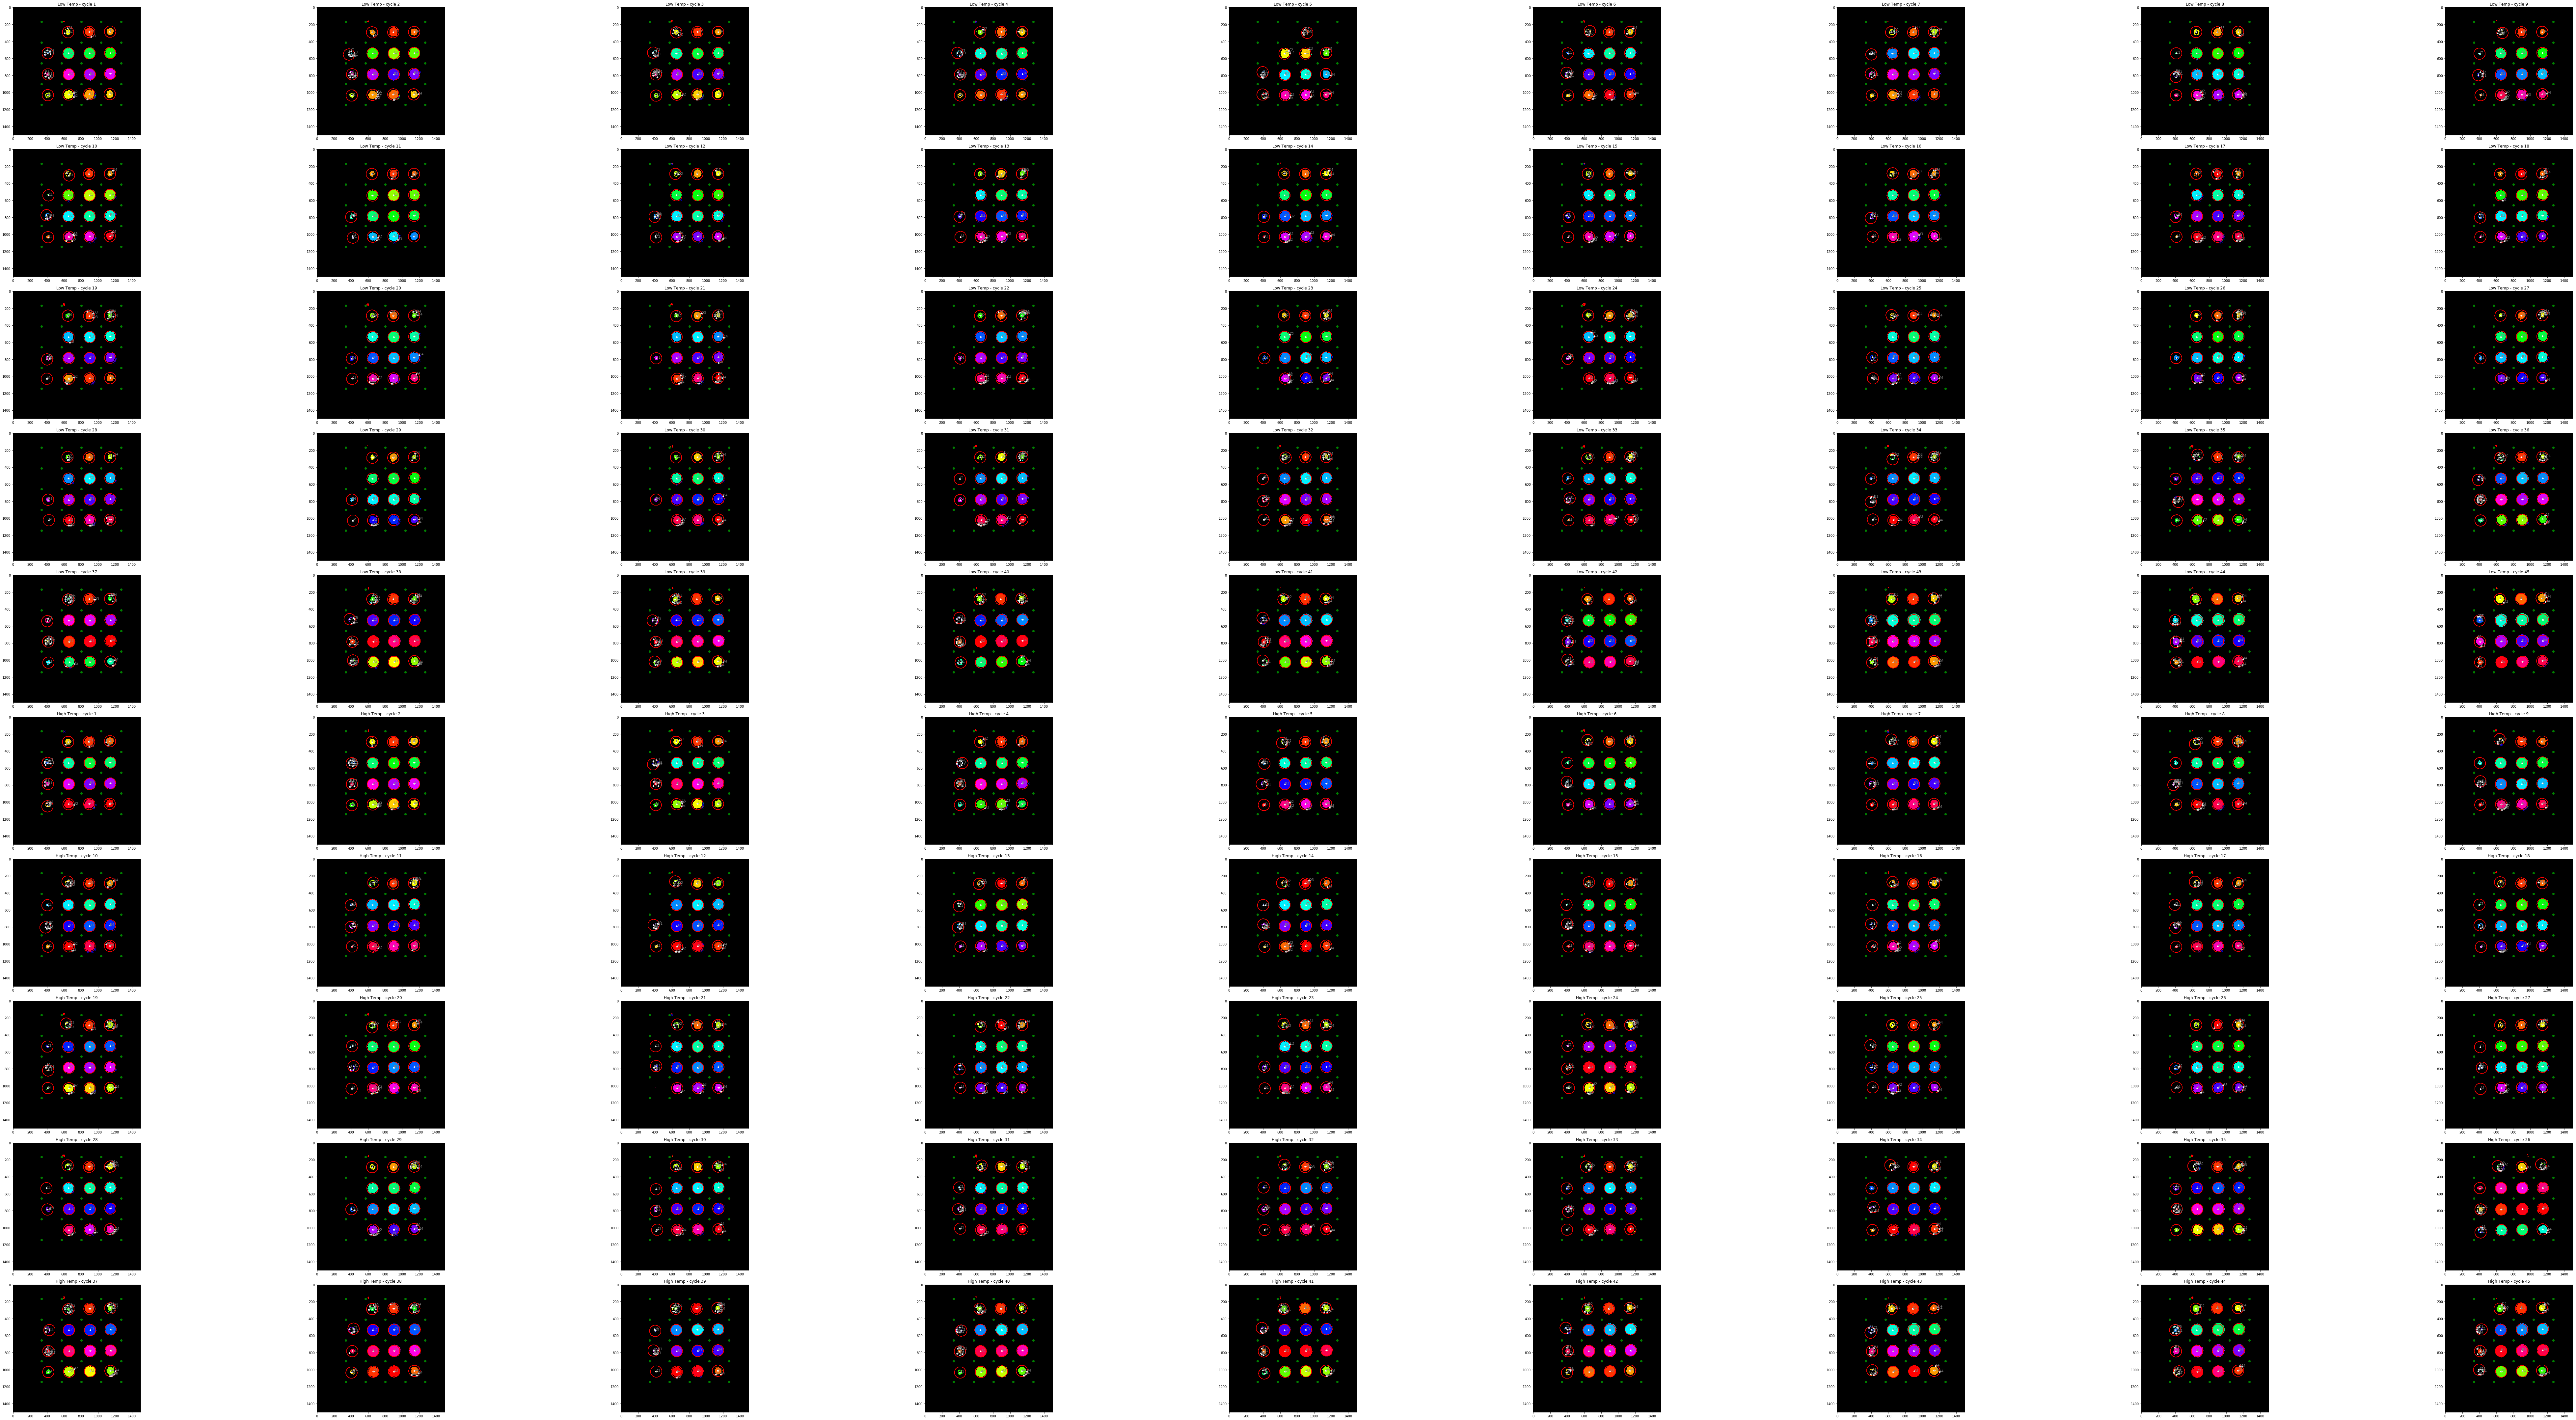

In [71]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict[temp_li[t]][c]['labeled']
        im_gray = im_dict[temp_li[t]][c]['gray']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')
        
        sorted_region_key = list(im_dict[temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
        
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict[temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y)
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center)

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('test2_circle.png')
plt.show()

In [72]:
df_cal_low = pd.DataFrame(region_intensity_dict['Low Temp'])
df_cal_low.index = range(1, 46)
df_cal_low = df_cal_low.reindex(sorted(df_cal_low.columns), axis=1)
df_cal_low

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,C3,C4,D1,D2,D3,D4
1,1277,11313,15921,6683,1756,23383,30253,19441,821,23118,30875,20902,0,2904,11615,5306
2,1499,10672,15121,5864,1350,22973,29434,18566,621,22809,30433,20804,0,3004,11784,5326
3,1227,10667,14560,5903,1595,22992,28414,17849,681,22294,29270,19268,0,2611,11232,4845
4,1288,10566,14870,6259,1199,21906,27310,17289,1020,21219,28233,19432,0,2671,11303,5126
5,711,13099,15135,4843,654,19276,19950,6855,0,11091,14055,5095,0,0,1037,0
6,1212,11192,15764,8752,894,21189,27406,18947,448,16920,26852,19176,0,1096,7273,3525
7,1577,10507,15270,8228,1224,20605,26572,18771,400,16960,27127,19686,0,1361,7759,4646
8,1466,10859,15353,8353,1028,20671,26695,18516,304,17421,27241,19480,0,1701,8032,4479
9,723,10564,14958,6994,980,20675,26359,17066,343,17009,26466,18199,0,874,7081,3187
10,1146,10331,14457,7427,958,19961,25238,17304,241,16471,25868,18544,0,1209,7306,3511


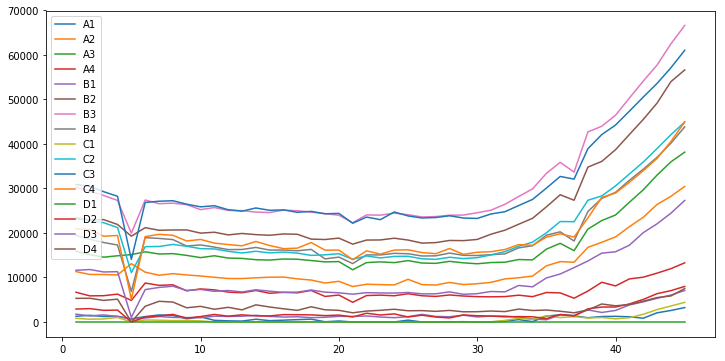

In [73]:
df_cal_low.plot(figsize=(12, 6))

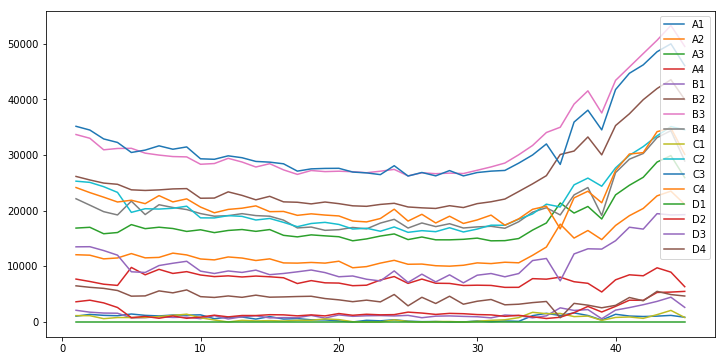

In [74]:
df_cal_high = pd.DataFrame(region_intensity_dict['High Temp'])
df_cal_high.index = range(1, 46)
df_cal_high = df_cal_high.reindex(sorted(df_cal_high.columns), axis=1)
df_cal_high.plot(figsize=(12, 6))

비교그래프

In [75]:
dict_before = pd.read_excel('F:/device/optics/32w_Realtime_test_5th/5차 1번카메라.xlsx', sheet_name=None, header=None)
row = list('ABCD')[::-1]
col_li = []
for y in range(4):
    for x in range(4):
        key = row[y]+str(x+1)
        col_li.append(key)

In [76]:
df_before = dict_before['cal60']
df_before.columns = col_li
df_before.index = range(1, 46)
df_low_norm_before = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
df_cal_low_norm = (df_cal_low-df_cal_low.loc[10:20].mean())/(df_cal_low.max()-df_cal_low.loc[10:20].mean())

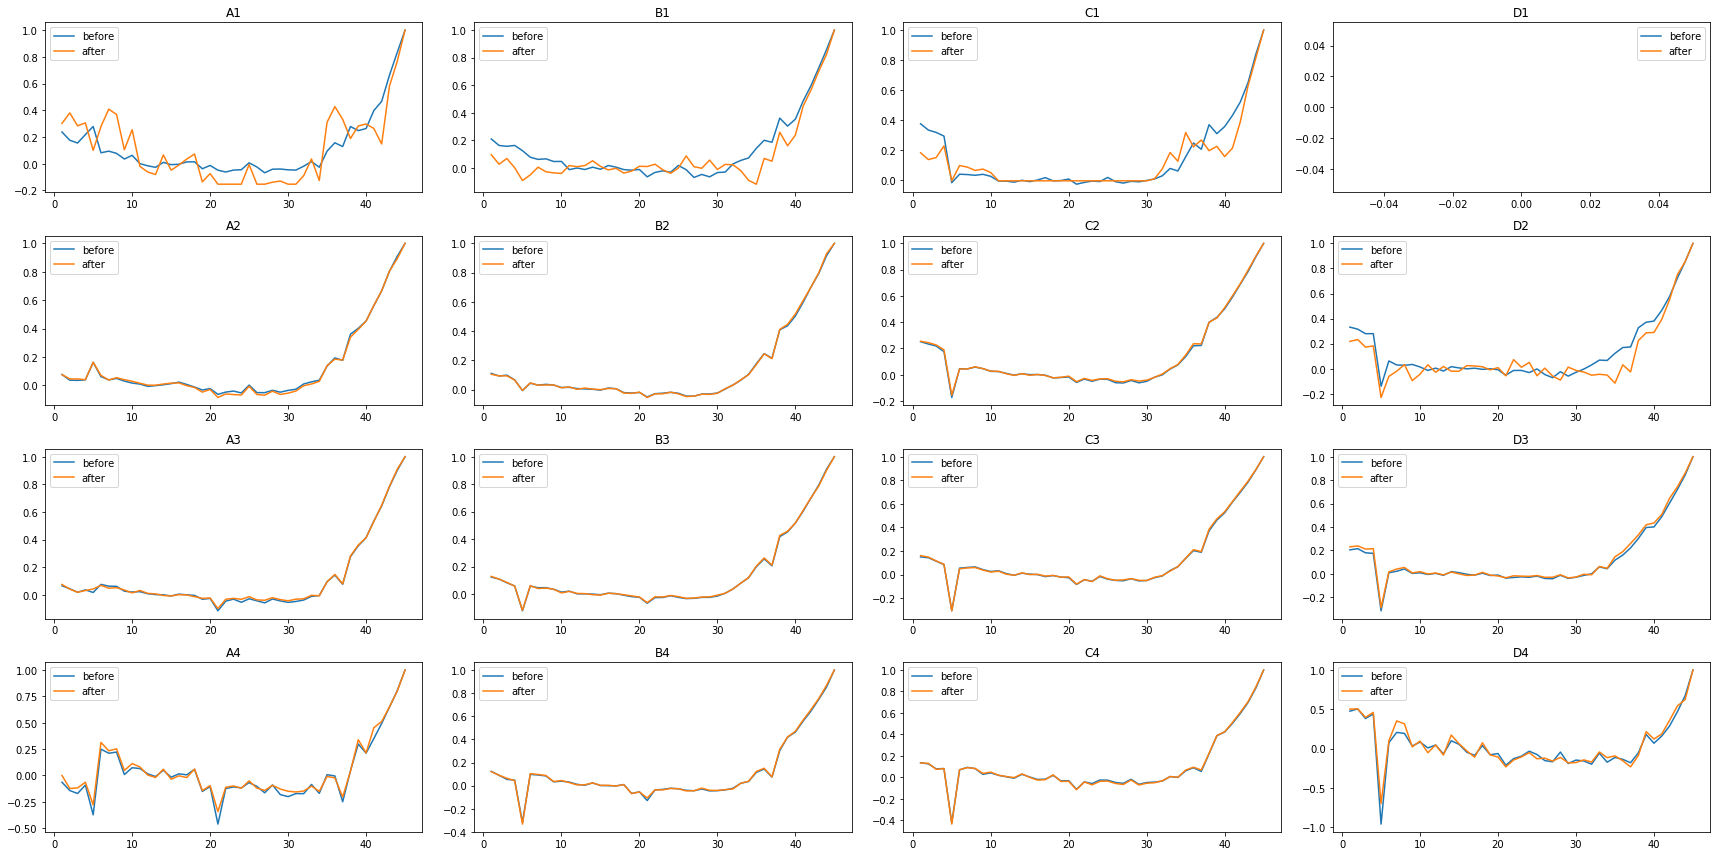

In [78]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
n = 0
for col in df_cal_low.columns:
    i = n%4
    j = n//4
    axes[i, j].plot(df_low_norm_before[col], label='before')
    axes[i, j].plot(df_cal_low_norm[col], label='after')
    axes[i, j].set_title(col)
    n += 1
    axes[i, j].legend(loc='best')
plt.tight_layout()
plt.savefig('compare_low_cal_circle.png')
plt.show()

In [79]:
df_high_before = dict_before['cal72']
df_high_before.columns = col_li
df_high_before.index = range(1, 46)
df_high_norm_before = (df_high_before - df_high_before.loc[10:20].mean())/(df_high_before.max()-df_high_before.loc[10:20].mean())
df_cal_high_norm = (df_cal_high-df_cal_high.loc[10:20].mean())/(df_cal_high.max()-df_cal_high.loc[10:20].mean())

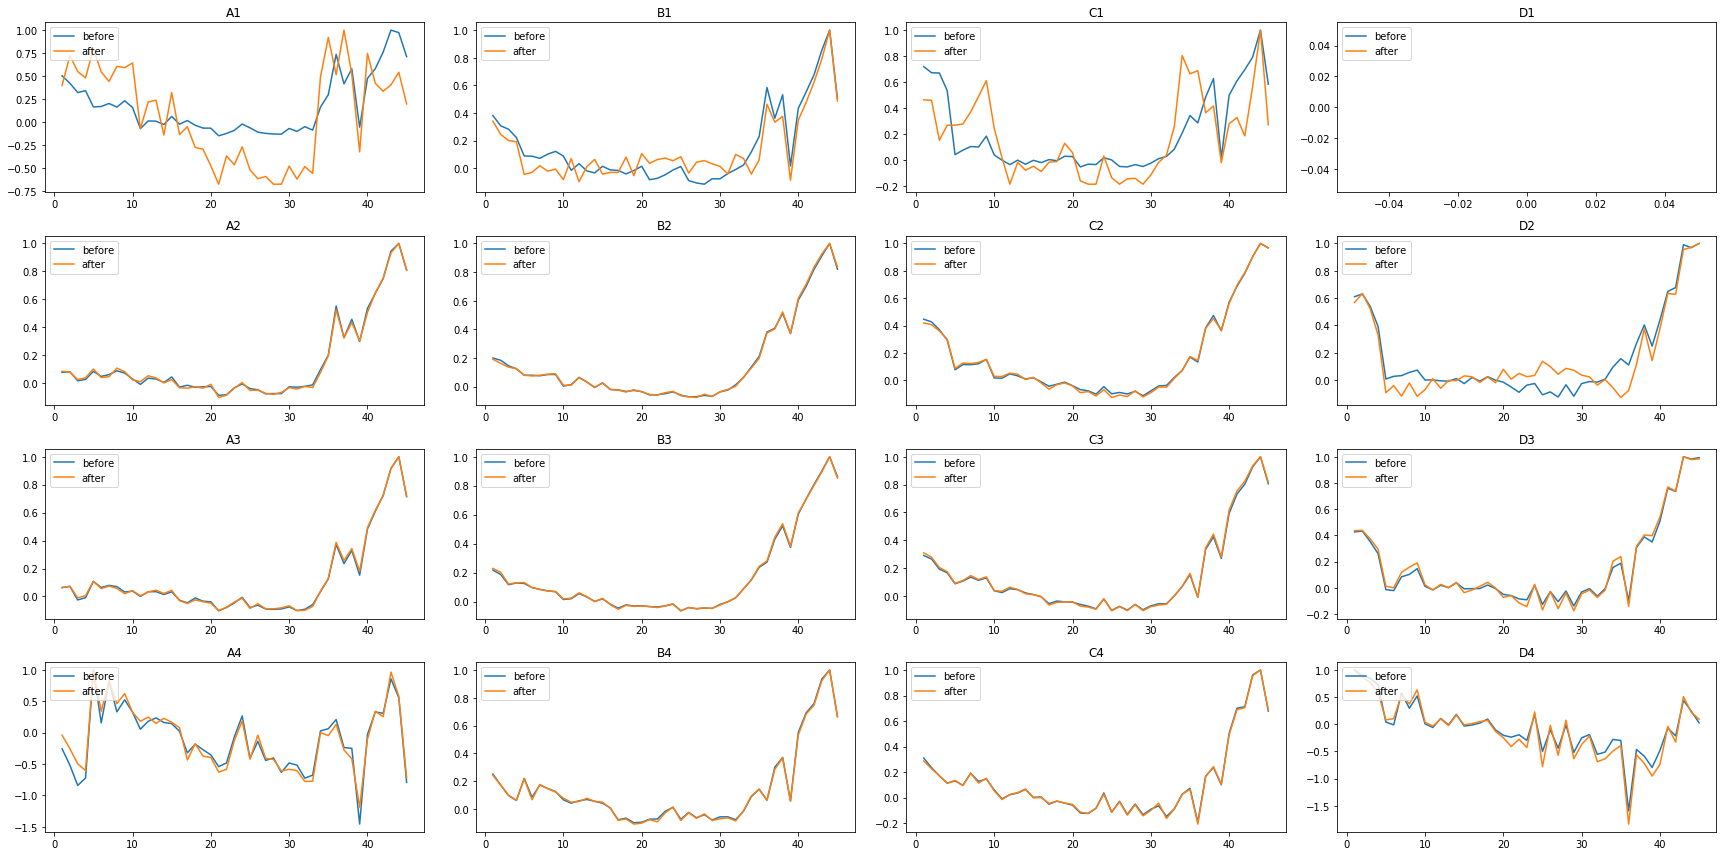

In [80]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
n = 0
for col in df_cal_high_norm.columns:
    i = n%4
    j = n//4
    axes[i, j].plot(df_high_norm_before[col], label='before')
    axes[i, j].plot(df_cal_high_norm[col], label='after')
    axes[i, j].set_title(col)
    n += 1
    axes[i, j].legend(loc='upper left')
plt.tight_layout()
plt.savefig('compare_high_cal_circle.png')
plt.show()